# Image Classification with Recurrent Neural Networks

Modified from original source code here: https://github.com/ageron/handson-ml/blob/master/14_recurrent_neural_networks.ipynb

### Make the notebook compatible with both Python 2 and 3

http://python-future.org/compatible_idioms.html

In [35]:
from __future__ import absolute_import, division, print_function

In [36]:
import numpy as np
import tensorflow as tf

### Plot graphs inline

In [37]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [38]:
print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)

1.3.0
1.13.1
2.0.2


### Download and extract the MNIST libraries

The original site where this dataset is available: http://yann.lecun.com/exdb/mnist/

In [39]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

# Store the MNIST data in mnist_data/
mnist = input_data.read_data_sets("mnist_data/")

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


### Helper function to display one digit image

Reshape the data from 1-D array to a 2-D array of 28x28 pixels

In [40]:
def display_digit(digit):
    plt.imshow(digit.reshape(28, 28), cmap="Greys", interpolation='nearest')

### Access the test data and the corresponding labels

Training data we'll access in batches when we execute this code

In [41]:
test_digits, test_labels = mnist.test.next_batch(200)

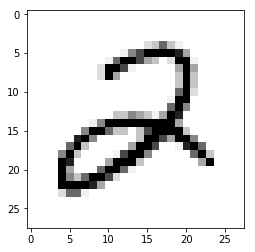

In [42]:
display_digit(test_digits[1])

In [43]:
test_labels[:5]

array([5, 2, 8, 2, 5], dtype=uint8)

### Set up the RNN

* *n_steps* is the number of time instances we want to consider, one dimension of the MNIST is assumed to be time instances
* *n_inputs* is the input for each time instance, this is the second dimension of the MNIST image
* Imagine **one row of pixels in the image is fed at every time instance**
* We use 150 neurons within each RNN memory cell
* The final output is a classification into digits 0-9

In [44]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

In [47]:
tf.reset_default_graph()

### Placeholders for training data and labels

* The inputs to an RNN will be of the form *[batch_size, n_steps, n_inputs]*, the number of time instances and the inputs for every instance are the second and third dimensions
* The labels are 0-9 

In [48]:
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

### Create a basic memory cell and dynamically build the RNN

* Specify the number of neurons in each cell
* *dynamic_rnn* allows you to feed the data in the form *[batch_size, n_steps, n_inputs]* directly to the neural network (reshaping and stacking the data is done internally)
* The result is the final outputs and the internal states of the RNN

In [49]:
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

### Connect the output layer

* Use a dense layer with no activation
* The softmax activation function is applied as a part of the cross-entropy cost function

In [50]:
logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)

In [51]:
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(loss)

### Check correctness and accuracy of the prediction

* Check whether the highest probability output in logits is equal to the y-label
* Check the accuracy across all predictions (How many predictions did we get right?)

In [52]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [53]:
init = tf.global_variables_initializer()

### Reshape the test digits

The inputs to an RNN will be of the form *[batch_size, n_steps, n_inputs]*, the number of time instances and the inputs for every instance are the second and third dimensions

In [54]:
test_digits = test_digits.reshape((-1, n_steps, n_inputs))

### Train and evaluate the model

In [55]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: test_digits, y: test_labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)


0 Train accuracy: 0.933333 Test accuracy: 0.88
1 Train accuracy: 0.92 Test accuracy: 0.92
2 Train accuracy: 0.94 Test accuracy: 0.935
3 Train accuracy: 0.94 Test accuracy: 0.96
4 Train accuracy: 0.973333 Test accuracy: 0.96
5 Train accuracy: 0.966667 Test accuracy: 0.95
6 Train accuracy: 0.986667 Test accuracy: 0.965
7 Train accuracy: 0.986667 Test accuracy: 0.97
8 Train accuracy: 0.946667 Test accuracy: 0.955
9 Train accuracy: 0.98 Test accuracy: 0.96
